In [ ]:
import torch
import torch.nn as nn
import random
import time
import math
import numpy as np
import torch.nn.functional as F
from torchtext.legacy import data
from torchtext.legacy import datasets
import spacy

In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [ ]:
en = spacy.load("en_core_web_sm")
de=spacy.load("de_core_news_sm")

In [ ]:
seed=1234

random.seed(1234)
np.random.seed(1234)
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.backends.cudnn.determininistic=True

In [ ]:
if torch.cuda.is_available():
  device="cuda"
else:
  device="cpu"

In [ ]:
device

'cuda'

In [ ]:
def tokenize_de(text):
  return [tok.text for tok in de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in en.tokenizer(text)]

In [ ]:
source=data.Field(init_token="<sos>",eos_token="<eos>",tokenize=tokenize_de,lower=True,batch_first=True)
target=data.Field(init_token="<sos>",eos_token="<eos>",tokenize=tokenize_en,lower=True,batch_first=True)

In [ ]:
train_data,valid_data,test_data=datasets.Multi30k.splits(exts=(".de",".en"),fields=(source,target))

In [ ]:
source.build_vocab(train_data,min_freq=2)
target.build_vocab(train_data,min_freq=2)

In [ ]:
train_iterator,valid_iterator,test_iterator=data.BucketIterator.splits((train_data,valid_data,test_data),batch_size=64,device=device)

In [ ]:
vars(train_data.examples[0])

{'src': ['zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'im',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.'],
 'trg': ['two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.']}

In [ ]:
batch=next(iter(train_iterator))

In [ ]:
len(source.vocab)

7855

In [ ]:
len(target.vocab)

5893

In [ ]:
class encoder(nn.Module):
  def __init__(self,input_dim,embed_dim,hidden_dim,n_layers,dropout,kernel_size,device,max_length=100):
    super().__init__()
    assert kernel_size % 2 == 1, "Kernel size must be odd!"
    
    self.input_dim=input_dim
    self.embed_dim=embed_dim
    self.hidden_dim=hidden_dim
    self.device=device
  #  self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
    self.tok_embedding = nn.Embedding(input_dim,embed_dim)
    self.pos_embedding = nn.Embedding(max_length,embed_dim)


    self.emb2hid = nn.Linear(embed_dim,hidden_dim)
    self.hid2emb = nn.Linear(hidden_dim,embed_dim)

    self.convs=nn.ModuleList([nn.Conv1d(in_channels=hidden_dim,out_channels=hidden_dim*2,
                                        kernel_size=kernel_size,padding=(kernel_size-1)//2) 
                                        for _ in range(n_layers)])
    self.dropout =nn.Dropout(dropout)

  def forward(self,src):
      #src = [batch size,src_len]
    batch_size = src.shape[0] 
    src_len = src.shape[1]

    pos =torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device)
      #pos=[batch_size,src_len]

    embed = self.tok_embedding(src)
    pos = self.pos_embedding(pos)
    embed = self.dropout(embed+pos)
    conv_input = self.emb2hid(embed)
    conv_input = conv_input.permute(0,2,1)
    

    for i , conv in enumerate(self.convs):
      conved = conv(self.dropout(conv_input))
      conved = F.glu(conved,dim=1)
      conved = (conv_input+conved)*0.7071067811865476
      conv_input = conved

      
    conved = self.hid2emb(conved.permute(0,2,1))
    combined = (conved+embed)*0.7071067811865476

    return conved,combined





In [ ]:
class decoder(nn.Module):
  def __init__(self,output_dim,embed_dim,hidden_dim,kernel_size,trg_pad_idx,n_layers,dropout,device,max_length=100):
    super().__init__()
    self.output_dim = output_dim
    self.embed_dim = embed_dim
    self.hidden_dim = hidden_dim
    self.device = device
    self.kernel_size=kernel_size
    self.trg_pad_idx=trg_pad_idx
    #self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)

    self.token_embed = nn.Embedding(output_dim,embed_dim)
    self.pos_embed = nn.Embedding(max_length,embed_dim)
    self.dropout = nn.Dropout(dropout)
    self.emb2hid = nn.Linear(embed_dim,hidden_dim)
    self.hid2emb = nn.Linear(hidden_dim,embed_dim)
    self.lin_out = nn.Linear(embed_dim,output_dim)

    self.convs=nn.ModuleList([nn.Conv1d(in_channels=hidden_dim,out_channels=hidden_dim*2,
                                        kernel_size=kernel_size) 
                                        for _ in range(n_layers)])
    
  def calculate_attention(self,embed,conved,encoder_conved,encoder_combined):

    conved_embed = self.hid2emb(conved.permute(0,2,1))
    combined = (conved_embed+embed)*0.7071067811865476

    energy = torch.matmul(combined,encoder_conved.permute(0,2,1))
    attention = F.softmax(energy,dim=2)
    attention_encoded = torch.matmul(attention,encoder_combined)
    attention_encoded=self.emb2hid(attention_encoded)
    attention_combined = (conved+attention_encoded.permute(0,2,1))*0.7071067811865476
    return attention,attention_combined

  
  def forward(self,encoder_conved,encoder_combined,target):
    batch_size = target.shape[0] 
    src_len = target.shape[1]
    pos =torch.arange(0,src_len).unsqueeze(0).repeat(batch_size,1).to(self.device)

    embed = self.token_embed(target)
    pos = self.pos_embed(pos)

    embed=self.dropout(embed+pos)
    conv_input = self.emb2hid(embed)
    conv_input = conv_input.permute(0,2,1)
    #conv_input = [batch_size,hidden_dim,src_len]
    batch_size = conv_input.shape[0]
    hidden_dimension = conv_input.shape[1] 

    for i,conv in enumerate(self.convs):
      conv_input =self.dropout(conv_input)
      padding = torch.zeros(batch_size,hidden_dimension,self.kernel_size-1).fill_(trg_pad_idx).to(self.device)
      padding_conv_input = torch.cat((padding,conv_input),dim=2)
      conved = conv(padding_conv_input)
      conved = F.glu(conved,dim=1)
      attention,conved = self.calculate_attention(embed,conved,encoder_conved,encoder_combined)

      conved = (conved+conv_input)*0.7071067811865476
      conv_input=conved
    
    conved = self.hid2emb(conved.permute(0,2,1))
    output = self.lin_out(conved)
    return output,attention


In [ ]:
class seq2seq(nn.Module):
  def __init__(self,encoder,decoder):
    super().__init__()
    self.encoder=encoder
    self.decoder=decoder
  
  def forward(self,src,trg):
    encoder_conved,encoder_combined=self.encoder(src)
    output,attention =self.decoder(encoder_conved,encoder_combined,trg)
    return output,attention


In [ ]:
input_dim=len(source.vocab)
output_dim = len(target.vocab)
hidden_dim = 512
embed_dim =256
kernel_size=3
n_layers=10
dropout=0.25
trg_pad_idx=target.vocab.stoi[target.pad_token]

In [ ]:
trg_pad_idx

1

In [ ]:
device

'cuda'

In [ ]:
enc=encoder(input_dim,embed_dim,hidden_dim,n_layers,dropout,kernel_size,device)

In [ ]:
enc

encoder(
  (tok_embedding): Embedding(7855, 256)
  (pos_embedding): Embedding(100, 256)
  (emb2hid): Linear(in_features=256, out_features=512, bias=True)
  (hid2emb): Linear(in_features=512, out_features=256, bias=True)
  (convs): ModuleList(
    (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (dropout): Dropout(p=0.25, inpl

In [ ]:
dec=decoder(output_dim,embed_dim,hidden_dim,kernel_size,trg_pad_idx,n_layers,dropout,device)

In [ ]:
dec

decoder(
  (token_embed): Embedding(5893, 256)
  (pos_embed): Embedding(100, 256)
  (dropout): Dropout(p=0.25, inplace=False)
  (emb2hid): Linear(in_features=256, out_features=512, bias=True)
  (hid2emb): Linear(in_features=512, out_features=256, bias=True)
  (lin_out): Linear(in_features=256, out_features=5893, bias=True)
  (convs): ModuleList(
    (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
    (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
  )
)

In [ ]:
device

'cuda'

In [ ]:
model=seq2seq(enc,dec).to(device)

In [ ]:
model

seq2seq(
  (encoder): encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

seq2seq(
  (encoder): encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (emb2hid): Linear(in_features=256, out_features=512, bias=True)
    (hid2emb): Linear(in_features=512, out_features=256, bias=True)
    (convs): ModuleList(
      (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
      (9): Conv1d(512, 1024, kernel_size=(3,), stride=(1,),

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,088,773 trainable parameters


In [ ]:
optim = torch.optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = target.vocab.stoi[target.pad_token]

loss_fn = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model,iterator,loss_fn):
  model.eval()
  epoch_loss=0
  with torch.no_grad():
    for i,batch in enumerate(iterator):
      src=batch.src
      trg=batch.trg
      pred,_=model(src,trg[:,:-1])
      pred_dim=pred.shape[-1]
      trg=trg[:,1:].contiguous().view(-1)
   # print(trg.shape)
      pred = pred.contiguous().view(-1, pred_dim)
      loss=loss_fn(pred,trg)
      epoch_loss+=loss.item()
  return epoch_loss/len(iterator)

In [ ]:
import math
import time

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
epochs=10
clip=0.1
best_valid_loss = float('inf')
for epoch in range(0,epochs):
  start_time = time.time()
  train_loss = train(model,train_iterator,optim,loss_fn,clip)
  valid_loss=evaluate(model,valid_iterator,loss_fn)
  end_time =time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'getoen-model.pt')
    
    
  print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


Epoch: 01 | Time: 1m 4s
	Train Loss: 3.430 | Train PPL:  30.872
	 Val. Loss: 2.749 |  Val. PPL:  15.624
Epoch: 02 | Time: 1m 4s
	Train Loss: 2.663 | Train PPL:  14.340
	 Val. Loss: 2.201 |  Val. PPL:   9.036
Epoch: 03 | Time: 1m 4s
	Train Loss: 2.212 | Train PPL:   9.133
	 Val. Loss: 1.963 |  Val. PPL:   7.120
Epoch: 04 | Time: 1m 4s
	Train Loss: 1.938 | Train PPL:   6.944
	 Val. Loss: 1.841 |  Val. PPL:   6.303
Epoch: 05 | Time: 1m 4s
	Train Loss: 1.746 | Train PPL:   5.732
	 Val. Loss: 1.758 |  Val. PPL:   5.800
Epoch: 06 | Time: 1m 4s
	Train Loss: 1.604 | Train PPL:   4.974
	 Val. Loss: 1.736 |  Val. PPL:   5.674
Epoch: 07 | Time: 1m 4s
	Train Loss: 1.495 | Train PPL:   4.460
	 Val. Loss: 1.692 |  Val. PPL:   5.432
Epoch: 08 | Time: 1m 4s
	Train Loss: 1.404 | Train PPL:   4.069
	 Val. Loss: 1.664 |  Val. PPL:   5.280
Epoch: 09 | Time: 1m 4s
	Train Loss: 1.327 | Train PPL:   3.770
	 Val. Loss: 1.659 |  Val. PPL:   5.252
Epoch: 10 | Time: 1m 4s
	Train Loss: 1.257 | Train PPL:   3.516


In [ ]:
model.load_state_dict(torch.load('getoen-model.pt'))

test_loss = evaluate(model, test_iterator, loss_fn)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.730 | Test PPL:   5.640 |


In [ ]:
def translate_sentence(sentence,source,target,model,device,max_len=50):
  model.eval()
  token=[]
  for word in sentence:
    token.append(source.vocab.stoi[word])
  
  token=[source.vocab.stoi[source.init_token]]+token+[source.vocab.stoi[source.eos_token]]
  token_tensor=torch.tensor(token,dtype=torch.long).unsqueeze(0).to(device)

  with torch.no_grad():
    encoder_conved,encoder_combined = model.encoder(token_tensor)
  
  trg_indexes = [target.vocab.stoi[target.init_token]]

  for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
          output,attention = model.decoder(encoder_conved,encoder_combined,trg_tensor)

        pred_token=output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == target.vocab.stoi[target.eos_token]:
          break
    
  trg_tokens = [target.vocab.itos[i] for i in trg_indexes]
    
  return trg_tokens[1:], attention      

        
  





In [ ]:

example_idx = 10

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'ballettklasse', 'mit', 'fünf', 'mädchen', ',', 'die', 'nacheinander', 'springen', '.']
trg = ['a', 'ballet', 'class', 'of', 'five', 'girls', 'jumping', 'in', 'sequence', '.']


In [ ]:
translation,attention=translate_sentence(src,source,target,model,device)
translation

['a',
 'ballet',
 'class',
 'with',
 'five',
 'girls',
 'jumping',
 'in',
 'sequence',
 '.',
 '<eos>']

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

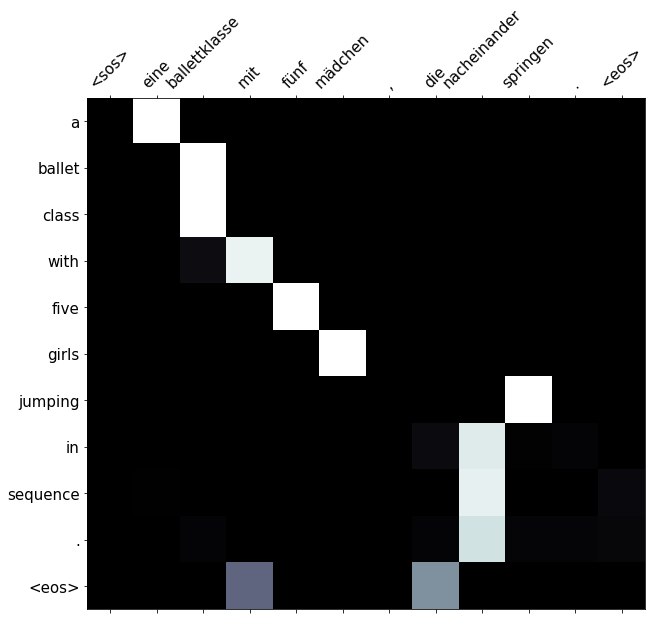

In [ ]:
display_attention(src,translation,attention)

In [ ]:
example_idx = 4

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['zwei', 'männer', 'stehen', 'am', 'herd', 'und', 'bereiten', 'essen', 'zu', '.']
trg = ['two', 'men', 'are', 'at', 'the', 'stove', 'preparing', 'food', '.']


In [ ]:
translation,attention=translate_sentence(src,source,target,model,device)
translation

['two',
 'men',
 'are',
 'standing',
 'at',
 'the',
 'stove',
 'preparing',
 'food',
 '.',
 '<eos>']

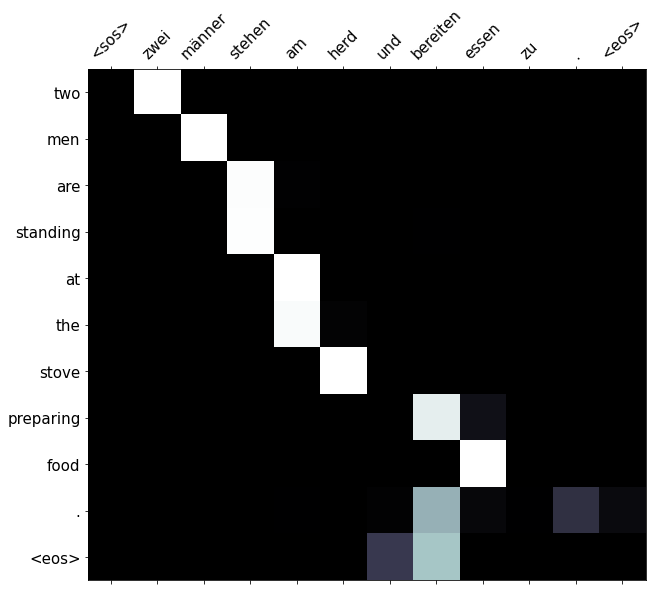

In [ ]:
display_attention(src,translation,attention)

In [ ]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, source, target, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 37.65
